# You're Toxic, I'm Slippin' Under: Toxic Comment Classification Challenge

#### STINTSY S13 Group 8
- VICENTE, Francheska Josefa
- VISTA, Sophia Danielle S.

## Introduction
In digital communities and forums on the internet, users often choose to remain anonymous as real names are not required when conversing with strangers online. With this anonymity comes the freedom to express one's thoughts without fear of being judged or recognized, yet this might also mean that users are free to say abusive sentiments with little to no repercussions. While most online forums and social media sites have various ways to moderate (e.g. moderators and staff that manually review posts and comments, a report button under messages, voting for comments and posts), these methods are not enough to combat the significant number of toxic comments made.

With this, ways to automate checking for toxicity in online text should be improved to foster a safe and respectful online environment.

## Toxic Comment Classification Challenge

The [`Toxic Comment Classification Challenge`](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview) is a Kaggle challenge by the [`Conversation AI team`](https://conversationai.github.io/), which is composed of researchers from both [`Jigsaw`](https://jigsaw.google.com/) and `Google`. This challlenge invites participants to build a multi-headed model that can accurately detect the types of toxicity (i.e.,toxic, severe toxic, obscene, threat, insult, and identity hate) better than Perspective’s [current models](https://github.com/conversationai/unintended-ml-bias-analysis).

The dataset given contains a large number of Wikipedia comments which have been labeled by human raters for toxic behavior.

## Requirements and Imports
Before starting, the relevant libraries and files in building and training the model should be loaded into the notebook first.

### Import
Several libraries are required to perform a thorough analysis of the dataset. Each of these libraries will be imported and described below:

#### Basic Libraries 
Import `numpy` and `pandas`.
- `numpy` contains a large collection of mathematical functions
- `pandas` contains functions that are designed for data manipulation and data analysis

In [1]:
import numpy as np
import pandas as pd

#### Visualization Libraries 
- `matplotlib.pyplot` contains functions to create interactive plots
- `seaborn` is a library based on matplotlib that allows for data visualization
- `wordcloud` contains functions for generating wordclouds from text data

**NOTE:** `wordcloud` should be installed using `conda install -c conda-forge wordcloud`

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

#### Natural Language Processing Libraries 
- `re` is a module that allows the use of regular expressions
- `nltk` provides functions for processing text data
- `stopwords` is a corpus from NLTK, which includes a compiled list of stopwords
- `Counter` is from Python's `collections` module, which is helpful for tokenization
- `string` contains functions for string operations

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#### Machine Learning Libraries

In [4]:
import sys
!{sys.executable} -m pip install scikit-multilearn

from skmultilearn.problem_transform import ClassifierChain
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

### Datasets and Files
There are four `.csv` files provided in the competition.
- `train.csv` is the training set, which contains comments and their classification (with the use of binary labels)
- `test.csv` is the test set, which contains comments and their corresponding IDs
- `sample_submission.csv` contains the correct submission format for the competition
- `test_labels.csv` was a file added after the competition closed

However, to do the task, we would only need to load two of these files: (1) `train.csv`, and (2) `test.csv`. These two `.csv` files will be loaded into the notebook using the [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

In [5]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

## Description of the Dataset

To see the the number of rows and columns for the `train` and `test` data, the [`shape`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html) property of the DataFrame is called.

In [6]:
train.shape

(159571, 8)

The `train` data has 159571 rows (instances) and eight (8) columns (features). An instance in our dataset represents a text and its categories. 

Next, the [`head`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) function is called to check the first few rows of the dataset. This will let us quickly check the features of the dataset.

In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


As seen by the function's output, the eight columns are: `id`, `comment_text`, `toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`. 

The first column `id` is an object that contains a unique identifier for the row. This is followed by the `comment_text` column, which holds the text that we need to categorize into the different toxic categories. The next six (6) columns—`toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`—are integer columns, with a value of either 0 or 1, which represents `True` or `False`, respectively. These six columns represent the different categories. If the value for a specific column is 1, it means that the `comment_text` can be classified as this category.

It is important to note, however, that each `comment_text` can be classified under more than one toxic category (e.g. a comment can fall under both `toxic` and `severe_toxic` as denoted by the multiple values of 1 per row).

In [8]:
test.shape

(153164, 2)

On the other hand, the `test` dataset has 153164 rows and two (2) columns.

In [9]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \r\n\r\n The title is fine as i...
2,00013b17ad220c46,""" \r\n\r\n == Sources == \r\n\r\n * Zawe Ashto..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Each instance represents a comment that we have to compute for its probaility for the different categories mentioned. Like the `train` data, the first column is the `id`, which is a unique identifier. After this is the `comment_text`, which holds the text that our model needs as input. 

## Exploratory Data Analysis (EDA)
In order to determine which model would fit our dataset, we would need to explore the given data. 

**Three exploratory data analysis questions have been identified and formulated:**
1. Which words occur most frequently in the `train` data?
2. Based on the `train` data, how correlated are the given categories?
3. What is the range of lengths of the `comment_text`?

To answer these questions, we used numerical summaries. Additionally, we used visualization techiniques in order to present and illustrate relationships in the data.

### Which words occur most frequently in the `train` data?

As a preliminary step in answering this question, all of the comments should be processed using tokenization, which is the process of separating pieces of text into words. 

For this, NLTK's [`RegexpTokenizer`](https://www.nltk.org/api/nltk.tokenize.regexp.html) is used to tokenize the text using RegEx. More specifically, the RegEx used is `\w+`, which retrieves all words (i.e. words with alphanumeric & underscore characters) from the text. Moreover, stopwords based on NLTK's Stopword corpus and single letters were filtered out of the tokens for a more accurate count of relevant words. 

It should be noted that tokenization was done for each toxic classification and for all comments as a whole, to contrast the differences of the frequently seen words in each category.

In [10]:
nltk.download('stopwords')

words = []
obscene = []
insult = [] 
toxic = []
severe_toxic = [] 
identity_hate = [] 
threat = []
tokenizer = nltk.RegexpTokenizer(r'\w+')
for index, x in train.iterrows():
    text = x ['comment_text']
    words += tokenizer.tokenize(text.lower())
    
    if x ['obscene'] == 1:
        obscene += tokenizer.tokenize(text.lower())
    if x ['insult'] == 1:
        insult += tokenizer.tokenize(text.lower())
    if x ['toxic'] == 1:
        toxic += tokenizer.tokenize(text.lower())
    if x ['severe_toxic'] == 1:
        severe_toxic += tokenizer.tokenize(text.lower())
    if x ['identity_hate'] == 1:
        identity_hate += tokenizer.tokenize(text.lower())
    if x ['threat'] == 1:
        threat += tokenizer.tokenize(text.lower())
        
all_words = Counter(words)
all_obscene = Counter(obscene)
all_insult = Counter(insult)
all_toxic = Counter(toxic)
all_severe_toxic = Counter(severe_toxic)
all_identity_hate = Counter(identity_hate)
all_threat = Counter(threat)

for stopword in stopwords.words("english"): 
    all_words.pop(stopword, None)
    all_obscene.pop(stopword, None)
    all_insult.pop(stopword, None)
    all_toxic.pop(stopword, None)
    all_severe_toxic.pop(stopword, None)
    all_identity_hate.pop(stopword, None)
    all_threat.pop(stopword, None)

for alpha_char in list(string.ascii_lowercase + string.ascii_uppercase):
    all_words.pop(alpha_char, None)
    all_obscene.pop(alpha_char, None)
    all_insult.pop(alpha_char, None)
    all_toxic.pop(alpha_char, None)
    all_severe_toxic.pop(alpha_char, None)
    all_identity_hate.pop(alpha_char, None)
    all_threat.pop(alpha_char, None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


To count the tokenized characters, Python's `Counter()` object was used to automatically count the number of tokens in the list of words retrieved above. The output for all the comments, arranged by total count in descending order, is as follows:

In [11]:
print('\n{}{}'.format('Token (All Comments)'.ljust(30), 'Count'))
for value, count in all_words.most_common(20):
    print('{}{}'.format(value.ljust(30), count))


Token (All Comments)          Count
article                       57661
wikipedia                     48427
page                          46460
talk                          37094
please                        29794
would                         29323
one                           29179
like                          28008
see                           21603
also                          20641
think                         20084
know                          19144
people                        18468
edit                          18288
articles                      16712
use                           16594
time                          15885
may                           15611
user                          14101
thanks                        13904


Next, the tokens for each toxic category will be shown below, arranged by total count in descending order.

In [12]:
print('\n{}{}'.format('Token (Insult)'.ljust(30), 'Count'))
for value, count in all_insult.most_common(10):
    print('{}{}'.format(value.ljust(30), count))

print('\n{}{}'.format('Token (Obscene)'.ljust(30), 'Count'))
for value, count in all_obscene.most_common(10):
    print('{}{}'.format(value.ljust(30), count))
    
print('\n{}{}'.format('Token (Toxic)'.ljust(30), 'Count'))
for value, count in all_toxic.most_common(10):
    print('{}{}'.format(value.ljust(30), count))
    
print('\n{}{}'.format('Token (Severe Toxic)'.ljust(30), 'Count'))
for value, count in all_severe_toxic.most_common(10):
    print('{}{}'.format(value.ljust(30), count))
    
print('\n{}{}'.format('Token (Identity Hate)'.ljust(30), 'Count'))
for value, count in all_identity_hate.most_common(10):
    print('{}{}'.format(value.ljust(30), count))
    
print('\n{}{}'.format('Token (Threat)'.ljust(30), 'Count'))
for value, count in all_threat.most_common(10):
    print('{}{}'.format(value.ljust(30), count))


Token (Insult)                Count
fuck                          7925
fucking                       2799
suck                          2792
nigger                        2781
go                            2235
ass                           2211
fat                           1926
faggot                        1867
bitch                         1733
shit                          1689

Token (Obscene)               Count
fuck                          9860
shit                          3212
fucking                       3192
suck                          3021
ass                           2846
nigger                        2727
go                            2147
wikipedia                     1905
bitch                         1795
like                          1541

Token (Toxic)                 Count
fuck                          9934
wikipedia                     3678
shit                          3622
like                          3512
nigger                        3300
fucking       

For a better visual representation of the frequency of these words, these words may be displayed in a wordcloud. Wordclouds are apt for this task as they give prominence to words based on their frequency.

A [`WordCloud()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) object is generated below, using the tokens from all comments.

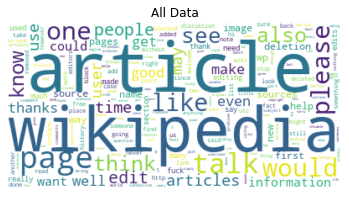

In [13]:
wordcloud = WordCloud(min_word_length = 3, background_color='white')
wordcloud.generate_from_frequencies(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('All Data')
plt.axis('off')
plt.show()

Next, several [`WordCloud()`](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) objects are generated using the tokens from each toxic category as follows:

#### Figure 1. Wordcloud of the Word Frequency of All of the Data

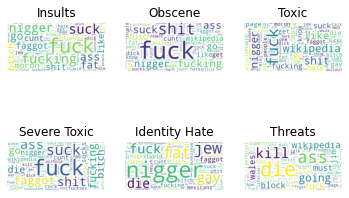

In [14]:
fig = plt.figure()

ax2 = fig.add_subplot(231)
wordcloud1 = WordCloud(min_word_length = 3, background_color='white')
wordcloud1.generate_from_frequencies(all_insult)
plt.imshow(wordcloud1)
plt.title('Insults')
plt.axis('off')

ax3 = fig.add_subplot(232)
wordcloud2 = WordCloud(min_word_length = 3, background_color='white')
wordcloud2.generate_from_frequencies(all_obscene)
plt.imshow(wordcloud2)
plt.title('Obscene')
plt.axis('off')

ax4 = fig.add_subplot(233)
wordcloud3 = WordCloud(min_word_length = 3, background_color='white')
wordcloud3.generate_from_frequencies(all_toxic)
plt.imshow(wordcloud3)
plt.title('Toxic')
plt.axis('off')

ax5 = fig.add_subplot(234)
wordcloud4 = WordCloud(min_word_length = 3, background_color='white')
wordcloud4.generate_from_frequencies(all_severe_toxic)
plt.imshow(wordcloud4)
plt.title('Severe Toxic')
plt.axis('off')

ax6 = fig.add_subplot(235)
wordcloud5 = WordCloud(min_word_length = 3, background_color='white')
wordcloud5.generate_from_frequencies(all_identity_hate)
plt.imshow(wordcloud5)
plt.title('Identity Hate')
plt.axis('off')

ax7 = fig.add_subplot(236)
wordcloud6 = WordCloud(min_word_length = 3, background_color='white')
wordcloud6.generate_from_frequencies(all_threat)
plt.imshow(wordcloud6)
plt.title('Threats')
plt.axis('off')

plt.show()

#### Figure 2. Wordcloud of the Word Frequency of Each of the Categories

From the list of frequent words outputted earlier and the wordclouds generated above (Figure 1 and 2), there are several things to note.

As expected of comments retrieved from Wikipedia's talk page edits, many of the words relate to Wikipedia itself (`article`, `articles`, `wikipedia`, `talk`, `page`, `edit`) and some words involve collaboration and communication between users for edits (`user`, `would`, `like`, `think`, `know`). Words such as `please` and `thanks` can be seen, indicating that many comments are civil and respectful.

However, most of the frequently appearing words coming from comments that fall under the various toxic categories are considered profane. Interestingly enough, specific types of words appear more frequently in some categories compared to others. For example, the category `identity_hate` has a higher frequency of various slurs, `threat` contains words relating to physical harm (e.g. `kill`, `die`), and `obscene` contains indecent words related to sexual acts or parts. Furthermore, the word `fuck` consistently appears as part of the ten most frequently seen words for all categories, even appearing as the most frequent word for `insult`, `obscene`, `toxic`, and `severe_toxic`.

### Based on the `train` data, how correlated are the given categories?
Since this challenge mainly focuses on determining the probability of a comment belonging to a specific category, we want to explore the correlations among the different categories. The correlation of each of the categories is computed using Pandas' [`corr`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) function. 

It should be noted that since there are only two values—0 and 1—possible for each of the categories, we would not have to worry for outliers.

In [15]:
correlation = train.corr()
correlation

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


Since it is hard to determine the correlation of the categories using just numbers, we can visualize these numbers using a [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

<AxesSubplot:>

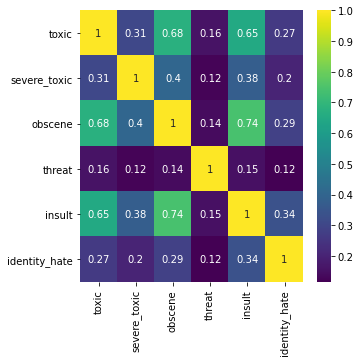

In [16]:
plt.figure (figsize = (5, 5))
sns.heatmap (data = correlation, xticklabels = correlation.columns.values, yticklabels = correlation.columns.values, cmap = 'viridis', annot=True)

#### Figure 3. Correlation Heatmap of the categories
From Figure 3, we can see that there is a low correlation between `threat` and all of the other categories. Additionally, `insult` and `obscene` has the highest correlation among the categories with a 0.74 or 74% correlation.

### What is the range of length of `comment_text`?

Determining the range of the length of the string `comment_text` could help us in determining on how long are the words, phrases or sentences our model needs to handle. The length of the longest string can be determined through the use of the [`len`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.len.html) and [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) functions.

In [17]:
train['comment_text'].str.len().describe()

count    159571.000000
mean        396.593961
std         594.387869
min           6.000000
25%          97.000000
50%         207.000000
75%         438.000000
max        5000.000000
Name: comment_text, dtype: float64

From this, we can see that there is at least one string in the `comment_text` column with a length of 5000. This is far from the mean length, which is only 396.

To effectively analyze the length of the comments, we can sort our data frame (i.e., using the [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) function) based on the length of the `comment_text` column, from the longest to the shortest.

In [18]:
arranged_index  = train['comment_text'].str.len().sort_values(ascending = False).index
arranged_length = train.reindex (arranged_index)

length = train['comment_text'].str.len().sort_values(ascending = False)
arranged_length ['string_length'] = length
arranged_length

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,string_length
131729,c0e076f0011acaa6,"""FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C ...",1,1,1,0,1,0,5000
133254,c8f01ac90c4adc27,FUCK YOU ALL!! FUCK YOU ALL!! FUCK YOU ALL!!...,1,1,1,0,1,0,5000
4174,0b2055f13934a41e,ii CAN STILL POST WITH THIS COMPUTER...I SAID ...,1,0,1,0,1,0,5000
56834,97e695cfd71944ed,i CAN STILL POST WITH THIS COMPUTER...I SAID B...,1,1,1,0,1,0,5000
156437,ce2d7821188dd30f,HUGE FAGGOT HUGE FAGGOT HUGE FAGGOT HUGE FAGGO...,1,1,1,0,1,1,5000
...,...,...,...,...,...,...,...,...,...
118850,7b3d18857df782cf,FUCK YOU,1,1,1,0,1,0,8
121074,87c06f935f2c6559,you suck,1,0,1,0,1,0,8
109985,4c5cde3ab1a618c9,{{unbloc,0,0,0,0,0,0,8
52442,8c4c53001134f290,"14:53,",0,0,0,0,0,0,6


As we can see, there are several rows with a string length of 5000. From the five comments shown, we can see that it is mostly made up of uppercase characters and copypasted words.

Additionally, we can see that there are **42 rows** that has a string length of 5000 for the `comment_text` column. 

In [19]:
len(arranged_length [arranged_length ['string_length'] == 5000])

42

Through the use of a [`box`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.box.html) plot, we can see how dispersed our data is.

<AxesSubplot:>

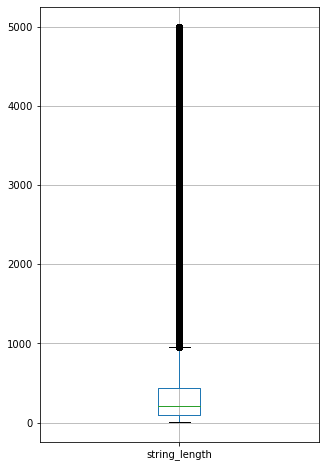

In [20]:
arranged_length ['string_length'].plot.box(grid='True', figsize=(5, 8))

#### Figure 4. Box Plot of the Length of `comment_text`
Using Figure 4, we can see that there are outliers in the length of the `comment_text` as there are comments with lengths that are higher than the upper whisker. Additionally, this boxplot visually complements what we have learned in the output of the [`describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function: 50% of the length of the `comment_text` column can be found within the range of 97 and 438, with an Interquartile range (IQR) of 341.

## Data Pre-Processing and Cleaning
For the data cleaning, we would check if the test and train data: (1) has the correct data type, (2) has **NaN** values, and (3) has duplicate rows. 

Once we have checked and fix these, we would expand the contractions found in `comment_text`, and remove other non-word characters. This is because we need the words to be a single word and not a combination of words, as we would be utilizing **TF-IFD** (Term Frequency–Inverse Document Frequency) in the later parts of the notebook. 

### Data Types of the Variables
For the data types of the columns, we are expecting that the `id` and the `comment_text` columns (for both the `train` and `test` data) are object types as these columns are made up of alphanumeric characters. For the succeeding columns of the `train` data, as these works as boolean flags that indicate the classification of the `comment_text`, these columns should be integers.

In [21]:
train.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [22]:
test.dtypes

id              object
comment_text    object
dtype: object

As the data types of the column are what we expected, we do not need to perform any cleaning on their data types.

### Checking for `NaN`
Additionally, we also need to check if there are rows with **NaN** value for any of the columns. This is because having a **NaN** value for any of the columns are not allowed as it might affect the learning or prediction of our model.

The combination of the [`isna`](https://pandas.pydata.org/docs/reference/api/pandas.isna.html) and [`sum`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html) functions would allow us to see how many rows have **NaN** values for each of the columns.

In [23]:
train.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [24]:
test.isna().sum()

id              0
comment_text    0
dtype: int64

With this, we are sure that all of the rows have values for each of the columns.

### Checking for Duplicate Rows
Then, we also have to check if there are rows that are duplicated. In the case that there are duplicated rows, they should be dropped as it might bias the models towards these duplicated rows.

We can check for duplicates using the [`duplicated`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html) function.

In [25]:
train [train.duplicated()]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [26]:
test [test.duplicated()]

,id,comment_text


Since we are now certain that there are no duplicates, we can now proceed with cleaning the content of the `comment_text` column.

### Expanding the Contractions
In Natural Language Processing, the `contractions` is one of the libraries that is used to expand contractions. However, even though this library worked for the train data, an *IndexError* was raised in the testing data. Upon researching, this stemmed from the fact that the `fix` function of this library can only handle UTF-8 characters. Due to this, a function that can handle this expansion was created.

In [27]:
def expand_contractions (comment_text):
    comment_text = re.sub(r"won\'t", "will not", comment_text)
    comment_text = re.sub(r"can\'t", "can not", comment_text)

    comment_text = re.sub(r"n\'t", " not", comment_text)
    comment_text = re.sub(r"\'re", " are", comment_text)
    comment_text = re.sub(r"what's", " is", comment_text)
    comment_text = re.sub(r"\'s", " ", comment_text) # to remove 's in possessive noun's
    comment_text = re.sub(r"\'d", " would", comment_text)
    comment_text = re.sub(r"\'ll", " will", comment_text)
    comment_text = re.sub(r"\'t", " not", comment_text)
    comment_text = re.sub(r"\'ve", " have", comment_text)
    comment_text = re.sub(r"\'m", " am", comment_text)
    return comment_text.strip ()

The `comment_text` column of both the `train` and `test` data would be mapped to the words returned by this function. Take note that the value of the `comment_text` column would be made into lowercase in order to lessen the vocabulary, which in turn would lower the dimension of the TF-IDF vector.

In [28]:
train ['comment_text'] = train ['comment_text'].map (lambda text : expand_contractions (text.lower ()))
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation\r\nwhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,d'aww! he matches this background colour i am ...,0,0,0,0,0,0
2,000113f07ec002fd,"hey man, i am really not trying to edit war. i...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nmore\r\ni can not make any real suggestio...",0,0,0,0,0,0
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::and for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,you should be ashamed of yourself \r\n\r\nthat...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"spitzer \r\n\r\numm, theres no actual article ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0,0,0,0,0,0


In [29]:
test ['comment_text'] = test ['comment_text'].map (lambda text : expand_contractions (text.lower ()))
test

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...
1,0000247867823ef7,== from rfc == \r\n\r\n the title is fine as i...
2,00013b17ad220c46,""" \r\n\r\n == sources == \r\n\r\n * zawe ashto..."
3,00017563c3f7919a,":if you have a look back at the source, the in..."
4,00017695ad8997eb,i do not anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \r\n i totally agree, this stuff is nothing ..."
153160,fffd7a9a6eb32c16,== throw from out field to home plate. == \r\n...
153161,fffda9e8d6fafa9e,""" \r\n\r\n == okinotorishima categories == \r\..."
153162,fffe8f1340a79fc2,""" \r\n\r\n == """"one of the founding nations of..."


However, from the current `test` and `train` data, we can see that if we make used TF-IDF on terms above, we would still see problems with whitespaces (e.g., new line characters, tab characters) and non-alphanumeric characters (e.g., equals sign, ellipses, repeated punctuation marks).

### Removing Non-word Characters
To remove the problem regarding white spaces and non-alphanumeric characters, we would be utilizing regular expressions to easily remove these two types of characters. To do this easily, we defined a function that would return a string that only has alphanumeric characters. 

In [30]:
def remove_other_chars (comment_text):
    comment_text = re.sub ('\W', ' ', comment_text)
    comment_text = re.sub ('\s+', ' ', comment_text)
    return comment_text.strip ()

Next, we would apply this function to the `comment_text` column of both the `train` and `test` data.

In [31]:
train ['comment_text'] = train ['comment_text'].map (lambda text : remove_other_chars (text.lower ()))
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can not make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when your vi...,0,0,0,0,0,0
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ho...,0,0,0,0,0,0
159568,ffee36eab5c267c9,spitzer umm theres no actual article for prost...,0,0,0,0,0,0
159569,fff125370e4aaaf3,and it looks like it was actually you who put ...,0,0,0,0,0,0


In [32]:
test ['comment_text'] = test ['comment_text'].map (lambda text : remove_other_chars (text.lower ()))
test

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule is more succesful then you wi...
1,0000247867823ef7,from rfc the title is fine as it is imo
2,00013b17ad220c46,sources zawe ashton on lapland
3,00017563c3f7919a,if you have a look back at the source the info...
4,00017695ad8997eb,i do not anonymously edit articles at all
...,...,...
153159,fffcd0960ee309b5,i totally agree this stuff is nothing but too ...
153160,fffd7a9a6eb32c16,throw from out field to home plate does it get...
153161,fffda9e8d6fafa9e,okinotorishima categories i see your changes a...
153162,fffe8f1340a79fc2,one of the founding nations of the eu germany ...


As we can see, the repetitive punctuations and the white space characters in the `comment_text` for both `test` and `train` data are now gone. We can say that our data is now clean. 

Although, we can see that there are still misspellings, this would not be cleaned. 

## Feature Engineering

In [33]:
X_train = train ['comment_text']
X_test = test ['comment_text']

In [34]:
tf_idf_vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 5000)

In [35]:
tf_idf_train = tf_idf_vectorizer.fit_transform(X_train)

In [36]:
tf_idf_test = tf_idf_vectorizer.transform(X_test)

In [37]:
count_vectorizer = CountVectorizer(stop_words = 'english', max_features = 5000)

In [38]:
count_train = count_vectorizer.fit_transform(X_train)

In [39]:
count_test = count_vectorizer.transform(X_test)

## Model Training

In [40]:
def compute_accuracy(predictions, actual):
    accuracy = np.sum (predictions == actual) / len (predictions) * 100
    return accuracy

### Trial #1: Using Classifier Chain

In [41]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
model = BinaryRelevance(GaussianNB())

In [42]:
X_train = train ['comment_text']
X_test = test ['comment_text']

In [43]:
y_train = train.loc[: ,'toxic' : 'identity_hate' ]

tf_idf_train_array = tf_idf_train.toarray()
pd.DataFrame(tf_idf_train_array, columns=tf_idf_vectorizer.get_feature_names(), index=X_train)

model.fit(tf_idf_train_array, y_train)
predictions = model.predict(X_train)

print(compute_accuracy(predictions, y_train))

### Trial #2: 6 Multinomial Naive Bayes

#### Trial #2.1: TF-IDF Vectorizer

In [44]:
X_train = train ['comment_text']
X_test = test ['comment_text']

In [45]:
tf_idf_train = tf_idf_vectorizer.fit_transform(X_train)

In [46]:
tf_idf_test = tf_idf_vectorizer.transform(X_test)

In [47]:
classes = train.columns [2:]
arr_model = []
counter = 0
for class_ in classes:
    y_train = train[class_]
    model = MultinomialNB ()
    model.fit(tf_idf_train, y_train)
    predictions = model.predict(tf_idf_train)
    arr_model.append(model)
    counter = counter + 1

In [48]:
counter = 0
for class_ in classes:
    print("Class: ", class_)
    y_train = train[class_]
    predictions = arr_model [counter].predict(tf_idf_train)
    print(compute_accuracy(predictions, y_train))
    counter = counter + 1

Class:  toxic
95.135080935759
Class:  severe_toxic
99.07940665910473
Class:  obscene
97.44753119301126
Class:  threat
99.70295354419036
Class:  insult
96.97689429783607
Class:  identity_hate
99.18594230781282


In [49]:
sample_submission = pd.read_csv('data' + '/sample_submission.csv')
sample_submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


In [50]:
sample_submission ['id'] = test ['id'] 
counter = 0

for class_ in classes:
    predictions = arr_model [counter].predict(tf_idf_test)
    sample_submission [class_] = predictions
    counter = counter + 1
    
sample_submission.to_csv('submission_tfidf_nb.csv', index = False) 

#### Trial #2.2: Count Vectorizer

In [51]:
X_train = train ['comment_text']
X_test = test ['comment_text']

In [52]:
count_train = count_vectorizer.fit_transform(X_train)

In [53]:
count_test = count_vectorizer.transform(X_test)

In [54]:
classes = train.columns [2:]
arr_model = []
counter = 0
for class_ in classes:
    y_train = train[class_]
    model = MultinomialNB ()
    model.fit(count_train, y_train)
    
    predictions = model.predict(count_train)
    arr_model.append(model)
    counter = counter + 1

In [55]:
counter = 0
for class_ in classes:
    print("Class: ", class_)
    y_train = train[class_]
    predictions = arr_model [counter].predict(count_train)
    print(compute_accuracy(predictions, y_train))
    counter = counter + 1

Class:  toxic
94.87250189570786
Class:  severe_toxic
98.35057748588403
Class:  obscene
97.05146925193175
Class:  threat
98.91396306346391
Class:  insult
96.49059039549793
Class:  identity_hate
98.14627971247909


In [56]:
sample_submission = pd.read_csv('data' + '/sample_submission.csv')
sample_submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


In [57]:
sample_submission ['id'] = test ['id'] 
counter = 0
for class_ in classes:
    predictions = arr_model [counter].predict(count_test)
    sample_submission [class_] = predictions
    counter = counter + 1
sample_submission.to_csv('submission_count_nb.csv', index = False) 

#### Hyperparameters

In [58]:
class hyper_parameter:
    def __init__(self, class_, alpha, fit_prior):
        self.class_ = class_
        self.alpha = alpha
        self.fit_prior = fit_prior

In [59]:
X = train ['comment_text']

In [60]:
hyperparameters = [{
    'alpha' : [1, 3, 5, 10, 15, 20, 50], 
    'fit_prior' : [False, True]
}]

In [61]:
final_hyperparameters = []
classes = train.columns [2:]
arr_model = []
counter = 0

for class_ in classes:
    print("Class: ", class_)
    y_train = train[class_]
    best_score = 0
    
    model = MultinomialNB ()
    
    X_train, X_val, y_train, y_val = train_test_split (X, y_train, random_state = 42, test_size = 0.25, stratify = y_train)
    
    X_train_sparse_matrix = count_vectorizer.fit_transform(X_train)
    X_validation_sparse_matrix = count_vectorizer.transform(X_val)
    
    for g in ParameterGrid(hyperparameters):

        model.set_params(**g)

        model.fit(X_train_sparse_matrix, y_train)
        predictions = model.predict (X_train_sparse_matrix)
        train_acc = compute_accuracy (predictions, y_train)

        predictions = model.predict (X_validation_sparse_matrix)
        val_acc = compute_accuracy (predictions, y_val)

        if val_acc > best_score:
            best_score = val_acc
            best_grid = g
    
    print("Best accuracy: ", best_score, "%")
    print("Best grid: ", best_grid)
    temp = hyper_parameter (class_, best_grid['alpha'], best_grid['fit_prior'])
    final_hyperparameters.append(temp)

Class:  toxic
Best accuracy:  94.85624044318553 %
Best grid:  {'alpha': 10, 'fit_prior': True}
Class:  severe_toxic
Best accuracy:  98.54360414107738 %
Best grid:  {'alpha': 50, 'fit_prior': True}
Class:  obscene
Best accuracy:  97.13734239089564 %
Best grid:  {'alpha': 5, 'fit_prior': True}
Class:  threat
Best accuracy:  99.37081693530193 %
Best grid:  {'alpha': 50, 'fit_prior': True}
Class:  insult
Best accuracy:  96.42794475221217 %
Best grid:  {'alpha': 3, 'fit_prior': True}
Class:  identity_hate
Best accuracy:  98.61379189331461 %
Best grid:  {'alpha': 50, 'fit_prior': True}


In [62]:
X_train = train ['comment_text']
count_train = count_vectorizer.fit_transform(X_train)

In [63]:
classes = train.columns [2:]
arr_model = []
counter = 0
for class_ in classes:
    print("Class: ", class_)
    y_train = train[class_]
    temp = final_hyperparameters [counter]
    model = MultinomialNB (alpha = temp.alpha, fit_prior = temp.fit_prior)

    model.fit(count_train, y_train)
    predictions = model.predict(count_train)
    print(compute_accuracy(predictions, y_train))
    arr_model.append(model)
    counter = counter + 1

Class:  toxic
94.79855362189872
Class:  severe_toxic
98.37125793533913
Class:  obscene
97.04457576878004
Class:  threat
99.25550381961634
Class:  insult
96.46928326575632
Class:  identity_hate
98.49972739407536


In [64]:
counter = 0
for class_ in classes:
    print("Class: ", class_)
    y_train = train[class_]
    predictions = arr_model [counter].predict(count_train)
    print(compute_accuracy(predictions, y_train))
    counter = counter + 1

Class:  toxic
94.79855362189872
Class:  severe_toxic
98.37125793533913
Class:  obscene
97.04457576878004
Class:  threat
99.25550381961634
Class:  insult
96.46928326575632
Class:  identity_hate
98.49972739407536


### Trial #3: 6 Logistic Regressions

#### Trial #3.2: TF-IDF Vectorizer

In [65]:
X_train = train ['comment_text']
X_test = test ['comment_text']

In [66]:
tf_idf_train = tf_idf_vectorizer.fit_transform(X_train)

In [67]:
tf_idf_test = tf_idf_vectorizer.transform(X_train)

In [68]:
classes = train.columns [2:]
arr_model = []
counter = 0
for class_ in classes:
    print("Class: ", class_)
    y_train = train[class_]
    model = LogisticRegression ()

    model.fit(tf_idf_train, y_train)
    predictions = model.predict(tf_idf_train)
    print(compute_accuracy(predictions, y_train))
    arr_model.append(model)
    counter = counter + 1

Class:  toxic
95.96919239711477
Class:  severe_toxic
99.10071378884633
Class:  obscene
97.98647623941694
Class:  threat
99.72739407536457
Class:  insult


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


97.28271427765696
Class:  identity_hate
99.25926390133546


In [69]:
sample_submission = pd.read_csv('data' + '/sample_submission.csv')
sample_submission ['id'] = test ['id'] 
counter = 0

for class_ in classes:
    predictions = arr_model [counter].predict(count_test)
    sample_submission [class_] = predictions
    counter = counter + 1
    
sample_submission.to_csv('submission_tf_idf_log_reg.csv', index = False) 

##### Hyperparameter Tuning

In [82]:
X = train ['comment_text']

final_C = []
classes = train.columns [2:]
arr_model = []
counter = 0

C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]

for class_ in classes:
    print("Class: ", class_)
    y_train = train[class_]
    best_score = 0
    
    X_train, X_val, y_train, y_val = train_test_split (X, y_train, random_state = 42, test_size = 0.25, stratify = y_train)
    
    X_train_sparse_matrix = tf_idf_vectorizer.fit_transform(X_train)
    X_validation_sparse_matrix = tf_idf_vectorizer.transform(X_val)
    
    for g in C_param_range:

        model = LogisticRegression (C = g)

        model.fit(X_train_sparse_matrix, y_train)
        predictions = model.predict (X_train_sparse_matrix)
        train_acc = compute_accuracy (predictions, y_train)

        predictions = model.predict (X_validation_sparse_matrix)
        val_acc = compute_accuracy (predictions, y_val)

        if val_acc > best_score:
            best_score = val_acc
            best_grid = g
    
    print("Best accuracy: ", best_score, "%")
    print("Best grid: ", best_grid)
    final_C.append(best_grid)

Class:  toxic


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Best accuracy:  95.7762013385807 %
Best grid:  10
Class:  severe_toxic


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Best accuracy:  99.06499887198255 %
Best grid:  1
Class:  obscene


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Best accuracy:  97.93447471987567 %
Best grid:  10
Class:  threat


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Best accuracy:  99.73178251823627 %
Best grid:  10
Class:  insult


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Best accuracy:  97.03958087885093 %
Best grid:  10
Class:  identity_hate


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best accuracy:  99.20537437645703 %
Best grid:  1


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [83]:
X_train = train ['comment_text']
X_test = test ['comment_text']
tf_idf_train = tf_idf_vectorizer.fit_transform(X_train)
tf_idf_test = tf_idf_vectorizer.transform(X_train)

classes = train.columns [2:]
arr_model = []
counter = 0
for class_ in classes:
    print("Class: ", class_)
    y_train = train[class_]
    model = LogisticRegression (C = final_C [counter])

    model.fit(tf_idf_train, y_train)
    predictions = model.predict(tf_idf_train)
    print(compute_accuracy(predictions, y_train))
    arr_model.append(model)
    counter = counter + 1

Class:  toxic


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


96.37528122277857
Class:  severe_toxic
99.10071378884633
Class:  obscene


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


98.30545650525472
Class:  threat


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


99.80134234917372
Class:  insult


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


97.5383998345564
Class:  identity_hate
99.25926390133546


In [84]:
sample_submission = pd.read_csv('data' + '/sample_submission.csv')
sample_submission ['id'] = test ['id'] 
counter = 0

for class_ in classes:
    predictions = arr_model [counter].predict(count_test)
    sample_submission [class_] = predictions
    counter = counter + 1
    
sample_submission.to_csv('submission_tf_idf_log_reg_tuned.csv', index = False) 

#### Trial #3.2: Count Vectorizer

In [70]:
X_train = train ['comment_text']
X_test = test ['comment_text']

In [71]:
count_train = count_vectorizer.fit_transform(X_train)

In [72]:
count_test = count_vectorizer.transform(X_test)

In [73]:
classes = train.columns [2:]
arr_model = []
counter = 0
for class_ in classes:
    print("Class: ", class_)
    y_train = train[class_]
    model = LogisticRegression ()

    model.fit(count_train, y_train)
    predictions = model.predict(count_train)
    print(compute_accuracy(predictions, y_train))
    arr_model.append(model)
    counter = counter + 1

Class:  toxic


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


96.05692763722732
Class:  severe_toxic


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


99.11575411572278
Class:  obscene


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


98.01217013116418
Class:  threat


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


99.76750161370174
Class:  insult


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


96.88414561543138
Class:  identity_hate
99.19596919239711


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [74]:
counter = 0
for class_ in classes:
    print("Class: ", class_)
    y_train = train[class_]
    predictions = arr_model [counter].predict(count_train)
    print(compute_accuracy(predictions, y_train))
    counter = counter + 1

Class:  toxic
96.05692763722732
Class:  severe_toxic
99.11575411572278
Class:  obscene
98.01217013116418
Class:  threat
99.76750161370174
Class:  insult
96.88414561543138
Class:  identity_hate
99.19596919239711


In [75]:
sample_submission = pd.read_csv('data' + '/sample_submission.csv')
sample_submission ['id'] = test ['id'] 
counter = 0

for class_ in classes:
    predictions = arr_model [counter].predict(count_test)
    sample_submission [class_] = predictions
    counter = counter + 1
    
sample_submission.to_csv('submission_count_log_reg.csv', index = False) 

## Feature Selection and Hyperparameter tuning

## Model Selection

## Insights and Conclusions

## Testing the Model

## References
Dickinson, B. (2021, February 12). *Generate meaningful word clouds in Python*. Medium. Retrieved May 30, 2022, from https://towardsdatascience.com/generate-meaningful-word-clouds-in-python-5b85f5668eeb 

Lukei. (2019, December 4). *Dealing with contractions in NLP*. Medium. Retrieved May 30, 2022, from https://medium.com/@lukei_3514/dealing-with-contractions-in-nlp-d6174300876b 

Raghunathan, D. (2020, June 9). *NLP in Python-Data Cleaning*. Medium. Retrieved May 30, 2022, from https://towardsdatascience.com/nlp-in-python-data-cleaning-6313a404a470 